In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
STIM_PROTOCOL = {
    "000": (1, "AS"),
    "001": (2, "AS"),
    "002": (5, "AS"),
    "003": (10, "AS"),
    "004": (0.5, "AS"),
    "005": (0.25, "AS"),
    "006": (0.1, "AS"),
    "007": (1, "1U"),
    "008": (2, "1U"),
    "009": (5, "1U"),
    "010": (7.5, "1U"),
    "011": (10, "1U"),
    "012": (1, "1L"),
    "013": (2, "1L"),
    "014": (5, "1L"),
    "015": (7.5, "1L"),
    "016": (10, "1L"),
    "017": (1, "2U"),
    "018": (2, "2U"),
    # "019": (5, "2U"),
    "020": (5, "2U"),
    "021": (7.5, "2U"),
    "022": (10, "2U"),
    "023": (1, "2L"),
    "024": (2, "2L"),
    # "025": (5, "2L"),
    "026": (5, "2L"),
    "027": (7.5, "2L"),
    "028": (10, "2L"),
    "029": (1, "3U"),
    "030": (2, "3U"),
    "031": (5, "3U"),
    "032": (7.5, "3U"),
    "033": (10, "3U"),
    "034": (1, "3L"),
    "035": (2, "3L"),
    "036": (5, "3L"),
    "037": (7.5, "3L"),
    "038": (10, "3L"),
    "039": (1, "4U"),
    "040": (2, "4U"),
    "041": (5, "4U"),
    "042": (7.5, "4U"),
    "043": (10, "4U"),
    "044": (1, "4L"),
    "045": (2, "4L"),
    "046": (5, "4L"),
    "047": (7.5, "4L"),
    "048": (10, "4L"),
}

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm

from cheese3d.anatomy import compute_measurements_df
from cheese3d.readers import read_3d_data

In [4]:
DATA_PATH = "demo-data"
COORDINATE_PATHS = {}
key_cols = ("run",)
for p in Path(DATA_PATH).glob("*/pose-3d/*.csv"):
    run = p.stem
    if run not in STIM_PROTOCOL.keys():
        continue
    COORDINATE_PATHS[(run,)] = p
data_keys = list(COORDINATE_PATHS.keys())
data_keys

[('024',),
 ('023',),
 ('015',),
 ('012',),
 ('046',),
 ('041',),
 ('048',),
 ('013',),
 ('014',),
 ('022',),
 ('040',),
 ('047',),
 ('038',),
 ('007',),
 ('000',),
 ('009',),
 ('036',),
 ('031',),
 ('030',),
 ('008',),
 ('037',),
 ('001',),
 ('039',),
 ('006',),
 ('042',),
 ('045',),
 ('020',),
 ('027',),
 ('018',),
 ('011',),
 ('016',),
 ('029',),
 ('044',),
 ('043',),
 ('017',),
 ('028',),
 ('010',),
 ('026',),
 ('021',),
 ('003',),
 ('004',),
 ('032',),
 ('035',),
 ('034',),
 ('033',),
 ('005',),
 ('002',)]

In [5]:
coord_data = {k: read_3d_data(v.parent.parent.as_posix())
              for k, v in COORDINATE_PATHS.items()}

meas_df = compute_measurements_df(coord_data, key_columns=key_cols)
meas_df

,run,measurement_group,measurement_name,measurement_units,measurement_type,measurement_value,std,count,timeseries
0,024,eye,eye-height-left,mm,distance,2.455728,0.007411,3241,"[2.456497937134305, 2.456470121674732, 2.45642..."
1,024,eye,eye-height-right,mm,distance,2.550920,0.007504,3241,"[2.538503621071123, 2.5384789089195987, 2.5383..."
2,024,eye,eye-width-left,mm,distance,3.904532,0.008391,3241,"[3.902638072499012, 3.9026646725145646, 3.9026..."
3,024,eye,eye-width-right,mm,distance,3.568571,0.007557,3241,"[3.5567388430295654, 3.55666135595315, 3.55677..."
4,024,eye,eye-area-left,mm^2,area,7.564281,0.030273,3241,"[7.561480823307555, 7.561376191183494, 7.56130..."
...,...,...,...,...,...,...,...,...,...
794,002,ear,ear-area-left,mm^2,area,9178.689064,3.927320,3208,"[9176.514524697071, 9176.54253626481, 9176.587..."
795,002,ear,ear-area-right,mm^2,area,80.346849,1.400350,3208,"[78.95443781708546, 78.95558507885309, 78.9579..."
796,002,mouth,mouth-area,mm^2,area,4.288836,0.149354,3208,"[4.222865909815116, 4.225434809956367, 4.22675..."
797,002,nose,nose-bulge-volume,mm^3,volume,8.612774,0.132185,3208,"[8.681995199741193, 8.680253917370937, 8.68236..."


In [6]:
def build_ephys_df(data_keys, run_map):
    df = []
    for key in tqdm(data_keys, desc="reading ephys"):
        run = key[0]
        with open(os.sep.join([DATA_PATH, "ephys-stim", f"{run}.npy"]), "rb") as f:
            stim_times = np.load(f)
        stim_amp, stim_loc = run_map[run]
        if stim_loc == "AS":
            stim_shank = "A"
            stim_depth = "A"
        else:
            stim_shank, stim_depth = stim_loc
        df.append([run,
                   stim_amp, len(stim_times),
                   stim_shank, stim_depth, "right",
                   stim_times])

    df = pd.DataFrame(df, columns=[*key_cols,
                                   "stim_amplitude", "nrepeats",
                                   "stim_shank", "stim_depth", "stim_side",
                                   "stim_times"])

    return df

ephys_df = build_ephys_df(data_keys, STIM_PROTOCOL)
ephys_df

reading ephys:   0%|          | 0/47 [00:00<?, ?it/s]

,run,stim_amplitude,nrepeats,stim_shank,stim_depth,stim_side,stim_times
0,024,2.00,10,2,L,right,"[4.800214745090378, 7.169620545603608, 9.70830..."
1,023,1.00,10,2,L,right,"[5.284498454064911, 7.5754797079294205, 10.306..."
2,015,7.50,10,1,L,right,"[4.741994300562261, 7.163102123657917, 9.82064..."
3,012,1.00,10,1,L,right,"[4.949773895277059, 7.5315445843268956, 10.220..."
4,046,5.00,10,4,L,right,"[4.867027718836826, 7.330857318786287, 9.87526..."
5,041,5.00,10,4,U,right,"[4.235481720467928, 6.513460467106747, 8.89138..."
6,048,10.00,10,4,L,right,"[4.978694431473655, 7.180810237801142, 9.37273..."
7,013,2.00,10,1,L,right,"[4.393560003570838, 7.028595971055948, 9.82378..."
8,014,5.00,10,1,L,right,"[5.363317093024926, 8.048169284091248, 10.5514..."
9,022,10.00,10,2,U,right,"[5.4388891706571565, 7.765960795976156, 10.054..."


In [7]:
def _select_ephys_row(row):
    ephys_row = ephys_df.query("run == @row.run")

    return ephys_row[["stim_amplitude",
                      "nrepeats",
                      "stim_shank",
                      "stim_depth",
                      "stim_side",
                      "stim_times"]].squeeze()

merge_df = pd.concat([meas_df, meas_df.apply(_select_ephys_row, axis=1)], axis=1)
merge_df

,run,measurement_group,measurement_name,measurement_units,measurement_type,measurement_value,std,count,timeseries,stim_amplitude,nrepeats,stim_shank,stim_depth,stim_side,stim_times
0,024,eye,eye-height-left,mm,distance,2.455728,0.007411,3241,"[2.456497937134305, 2.456470121674732, 2.45642...",2.0,10,2,L,right,"[4.800214745090378, 7.169620545603608, 9.70830..."
1,024,eye,eye-height-right,mm,distance,2.550920,0.007504,3241,"[2.538503621071123, 2.5384789089195987, 2.5383...",2.0,10,2,L,right,"[4.800214745090378, 7.169620545603608, 9.70830..."
2,024,eye,eye-width-left,mm,distance,3.904532,0.008391,3241,"[3.902638072499012, 3.9026646725145646, 3.9026...",2.0,10,2,L,right,"[4.800214745090378, 7.169620545603608, 9.70830..."
3,024,eye,eye-width-right,mm,distance,3.568571,0.007557,3241,"[3.5567388430295654, 3.55666135595315, 3.55677...",2.0,10,2,L,right,"[4.800214745090378, 7.169620545603608, 9.70830..."
4,024,eye,eye-area-left,mm^2,area,7.564281,0.030273,3241,"[7.561480823307555, 7.561376191183494, 7.56130...",2.0,10,2,L,right,"[4.800214745090378, 7.169620545603608, 9.70830..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,002,ear,ear-area-left,mm^2,area,9178.689064,3.927320,3208,"[9176.514524697071, 9176.54253626481, 9176.587...",5.0,10,A,A,right,"[4.680216599003238, 7.17386209700391, 9.788851..."
795,002,ear,ear-area-right,mm^2,area,80.346849,1.400350,3208,"[78.95443781708546, 78.95558507885309, 78.9579...",5.0,10,A,A,right,"[4.680216599003238, 7.17386209700391, 9.788851..."
796,002,mouth,mouth-area,mm^2,area,4.288836,0.149354,3208,"[4.222865909815116, 4.225434809956367, 4.22675...",5.0,10,A,A,right,"[4.680216599003238, 7.17386209700391, 9.788851..."
797,002,nose,nose-bulge-volume,mm^3,volume,8.612774,0.132185,3208,"[8.681995199741193, 8.680253917370937, 8.68236...",5.0,10,A,A,right,"[4.680216599003238, 7.17386209700391, 9.788851..."


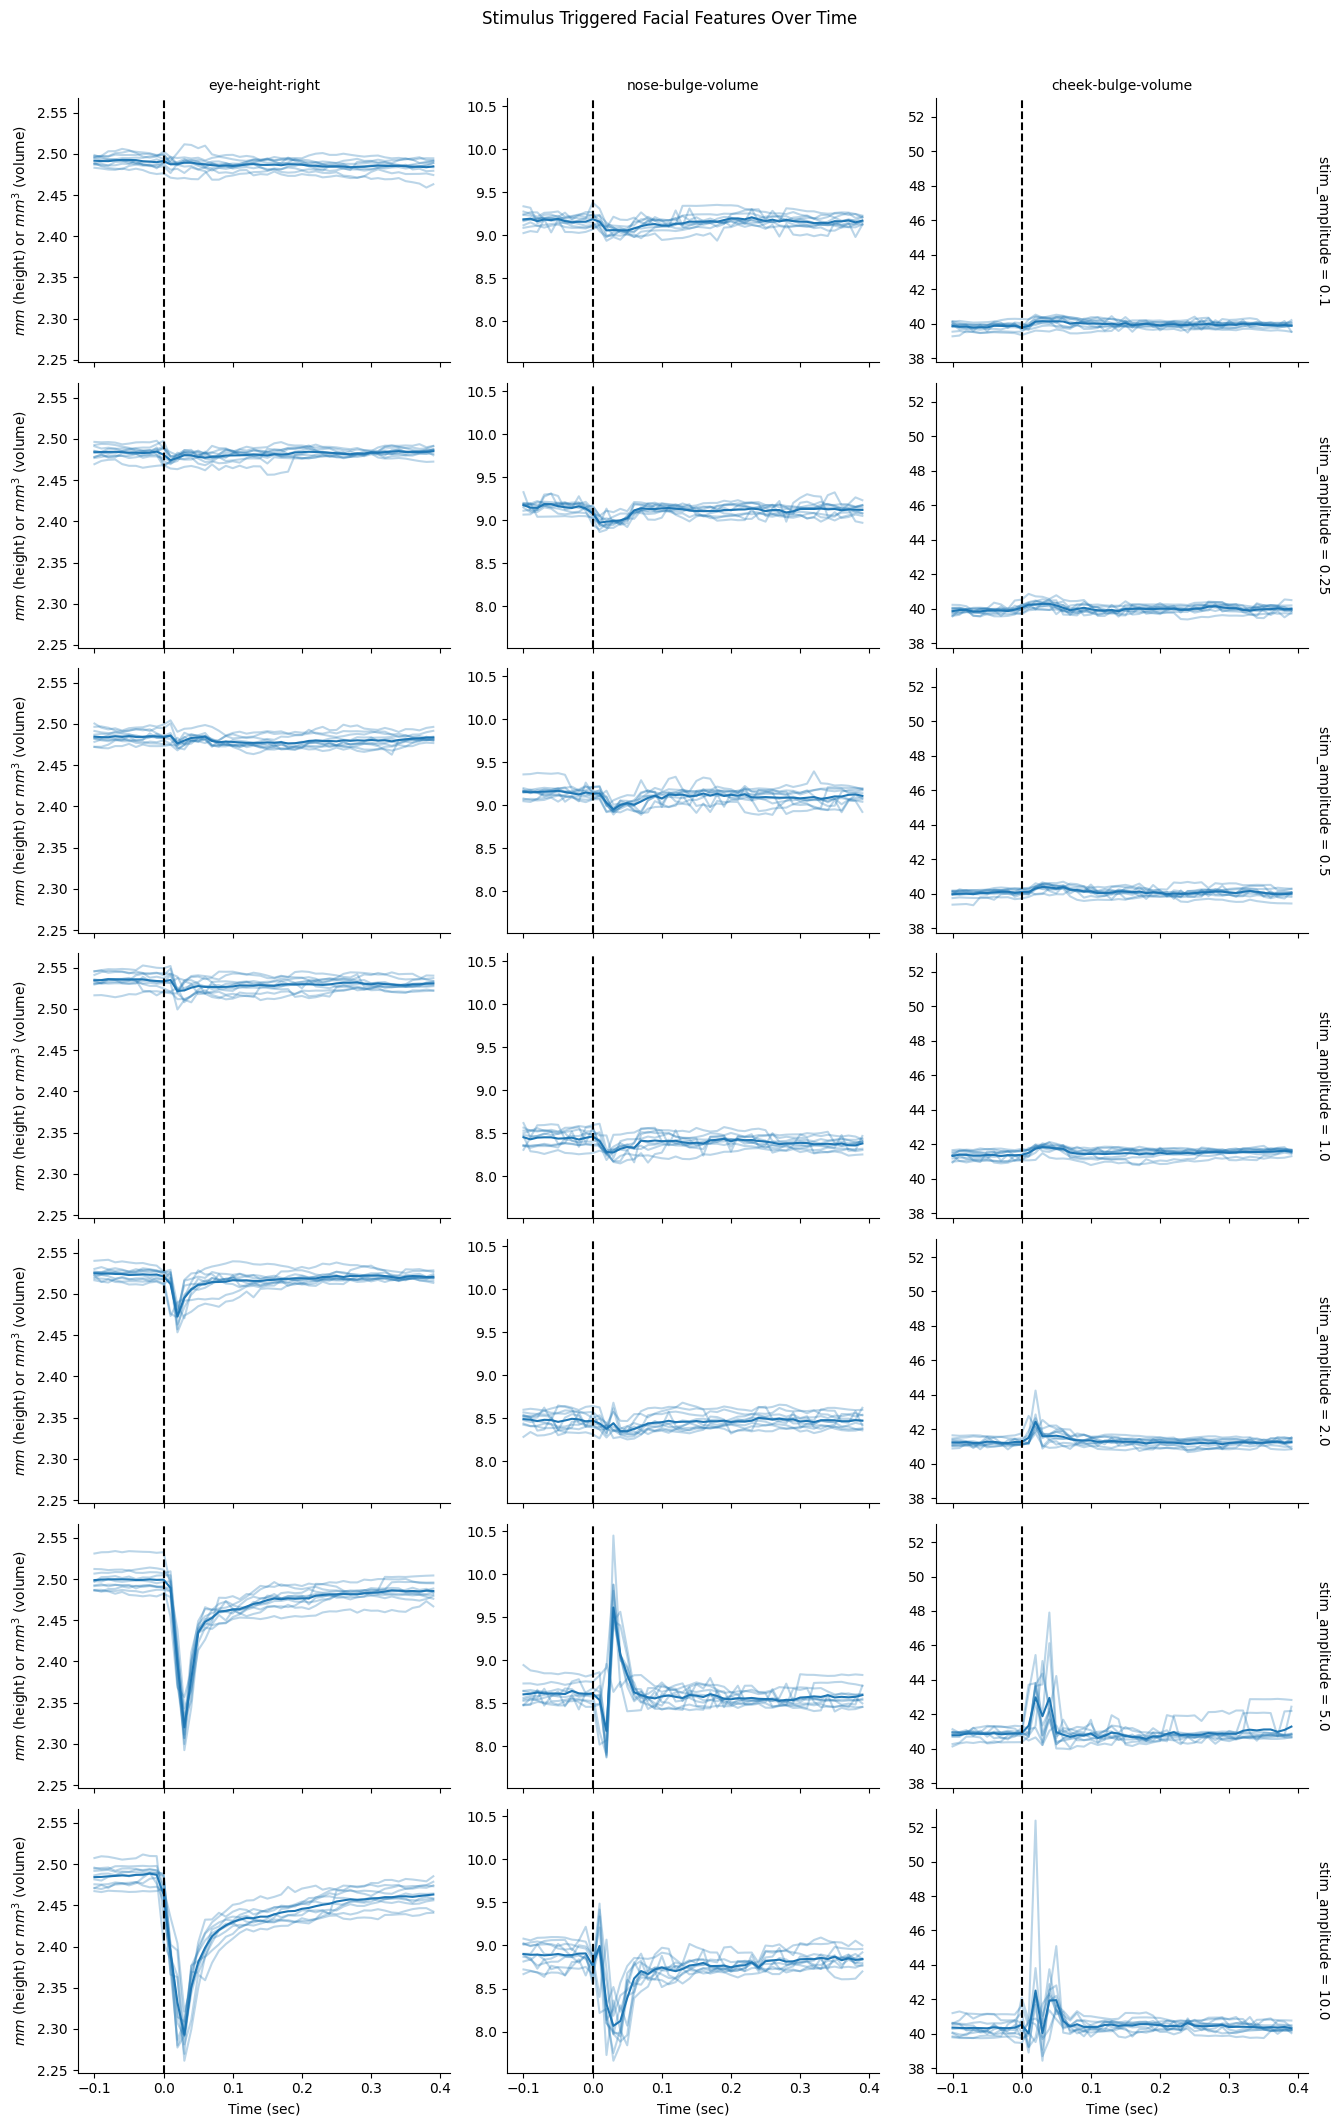

In [16]:
def _time_to_frame(ts):
    return np.floor(ts * 100).astype(int)

def plot_stim_align_helper(stim_times, timeseries, color):
    stim_times = _time_to_frame(stim_times.values[0])
    timeseries = timeseries.values[0]
    t_prestim = int(0.1 * 100) # 0.1 seconds before stim
    t_poststim = int(0.4 * 100) # 0.4 seconds after stim
    ys = [timeseries[(t - t_prestim):(t + t_poststim)] for t in stim_times]
    xs = [(np.arange(len(y)) - t_prestim) / 100 for y in ys]
    for x, y in zip(xs, ys):
        sns.lineplot(x=x, y=y, color=color, alpha=0.3)
    sns.lineplot(x=np.concatenate(xs), y=np.concatenate(ys),
                 color=color, errorbar=None)
    plt.axvline(0, color="black", linestyle="dashed")

measurements = ["eye-height-right",
                "nose-bulge-volume",
                "cheek-bulge-volume"]
g = sns.FacetGrid(merge_df.query("stim_shank == 'A' & stim_depth == 'A' & "
                                 "measurement_name in @measurements"),
                  row="stim_amplitude", col="measurement_name",
                  row_order=merge_df["stim_amplitude"].unique().sort(),
                  col_order=measurements,
                  sharey="col",
                  aspect=1.5,
                  margin_titles=True)
g.map(plot_stim_align_helper, "stim_times", "timeseries")
g.figure.suptitle(f"Stimulus Triggered Facial Features Over Time", y=1.01)
g.set_xlabels("Time (sec)")
g.set_ylabels("$mm$ (height) or $mm^3$ (volume)")
g.set_titles(col_template="{col_name}")
sns.despine(g.figure)
g.tight_layout()